In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from math import sqrt

In [66]:
df = pd.read_csv("data/train.csv")
pd.options.mode.chained_assignment = None
df_miss = df.copy()

# Removing values
Created random missing values and saving true values to lists to test accuracy of imputation methods

In [67]:
np.random.seed(42)

row_count = df_miss.shape[0]

chosen_idx1 = list(np.random.choice(row_count, replace=False, size=round(row_count*0.12)))
chosen_idx2 = list(np.random.choice(row_count, replace=False, size=round(row_count*0.03)))
chosen_idx3 = list(np.random.choice(row_count, replace=False, size=round(row_count*0.23)))

df_miss["Hepatomegaly"].iloc[chosen_idx1] = None
df_miss["Cholesterol"].iloc[chosen_idx2] = None
df_miss["Copper"].iloc[chosen_idx3] = None

hep_true = df["Hepatomegaly"].iloc[chosen_idx1].tolist()
chol_true = df["Cholesterol"].iloc[chosen_idx2].tolist()
cop_true = df["Copper"].iloc[chosen_idx3].tolist()

In [68]:
df_miss.isna().sum()

id                  0
N_Days              0
Drug                0
Age                 0
Sex                 0
Ascites             0
Hepatomegaly      949
Spiders             0
Edema               0
Bilirubin           0
Cholesterol       237
Albumin             0
Copper           1818
Alk_Phos            0
SGOT                0
Tryglicerides       0
Platelets           0
Prothrombin         0
Stage               0
Status              0
dtype: int64

# Imputing values

In [69]:
df_imp1 = df_miss.copy()
df_imp2 = df_miss.copy()
df_imp3 = df_miss.copy()

## Mean & Mode
For the first imputation method I simply took the mode of the categorical value and the mean of the numerical values

In [70]:
df_imp1["Hepatomegaly"] = df_imp1["Hepatomegaly"].fillna(df_imp1["Hepatomegaly"].mode().iat[0])
df_imp1["Cholesterol"] = df_imp1["Cholesterol"].fillna(df_imp1["Cholesterol"].mean())
df_imp1["Copper"] = df_imp1["Copper"].fillna(df_imp1["Copper"].mean())

hep_pred1 = df_imp1["Hepatomegaly"].iloc[chosen_idx1].tolist()
chol_pred1 = df_imp1["Cholesterol"].iloc[chosen_idx2].tolist()
cop_pred1 = df_imp1["Copper"].iloc[chosen_idx3].tolist()

df_imp1.isna().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [71]:
df.dtypes

id                 int64
N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object

## 2. KNNImputer
K-nearest neighbor sklearn imputer
First have to encode categorical values since it only works on numerical values
Encoded true values as well to compare to imputed values

In [72]:
encoder = OrdinalEncoder()
cat_cols = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Status"]

def encode(data):
    """function to encode non-null data and replace it in the original data"""
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

for columns in cat_cols:
    encode(df_imp2[columns])

df_enc = df.copy()
for columns in cat_cols:
    encode(df_enc[columns])

hep_true_enc = df_enc["Hepatomegaly"].iloc[chosen_idx1].tolist()
chol_true_enc = df_enc["Cholesterol"].iloc[chosen_idx2].tolist()
cop_true_enc = df_enc["Copper"].iloc[chosen_idx3].tolist()

Checking amount of neighbors to choose, all have same curve so 2 is fine

C:\Users\dagi\AppData\Local\Temp\ipykernel_17480\3108877489.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_imp2.loc[:, :] = knn_imp.fit_transform(df_imp2)


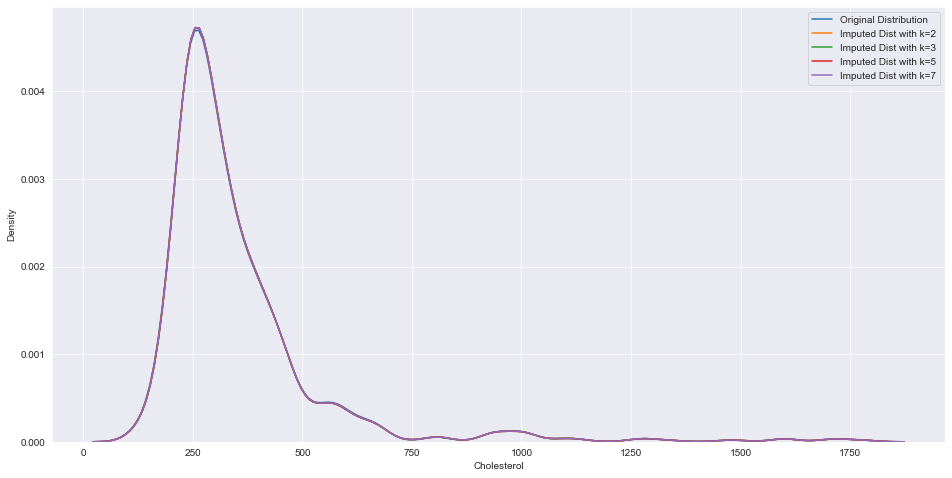

In [73]:
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
sns.kdeplot(df_imp2["Cholesterol"], label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    df_imp2.loc[:, :] = knn_imp.fit_transform(df_imp2)
    sns.kdeplot(df_imp2["Cholesterol"], label=f"Imputed Dist with k={k}")

plt.legend();

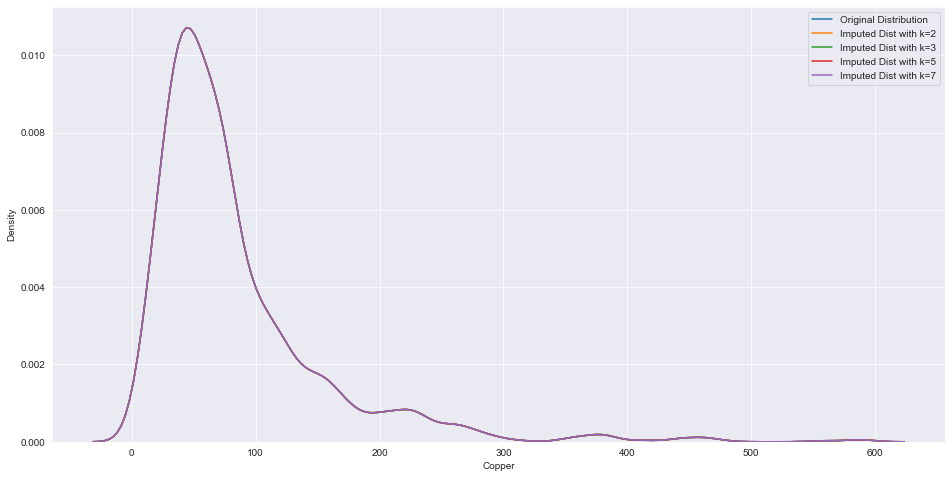

In [74]:
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
sns.kdeplot(df_imp2["Copper"], label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    df_imp2.loc[:, :] = knn_imp.fit_transform(df_imp2)
    sns.kdeplot(df_imp2["Copper"], label=f"Imputed Dist with k={k}")

plt.legend();

In [75]:
knn_imp = KNNImputer(n_neighbors=2)
df_imp2 = pd.DataFrame(np.round(knn_imp.fit_transform(df_imp2)),columns = df_imp2.columns)

hep_pred2 = df_imp2["Hepatomegaly"].iloc[chosen_idx1].tolist()
chol_pred2 = df_imp2["Cholesterol"].iloc[chosen_idx2].tolist()
cop_pred2 = df_imp2["Copper"].iloc[chosen_idx3].tolist()

# Scores
F1 score is 0-1 with 1 being best and 0 being worst
Root-mean-square deviation is 0 to +inf and the lower the value the better

## 1. Mean and Mode scores

In [78]:
hep_score1 = f1_score(hep_true, hep_pred1, pos_label="Y")
chol_score1 = sqrt(mean_squared_error(chol_true, chol_pred1))
cop_score1 = sqrt(mean_squared_error(cop_true, cop_pred1))
# chol_score1 = r2_score(chol_true, chol_pred1)
# cop_score1 = r2_score(cop_true, cop_pred1)

print(f"Hepatomgegaly F1 Score: {hep_score1}")
print(f"Cholesterol RMSE Score: {chol_score1}")
print(f"Copper RMSE Score: {cop_score1}")

Hepatomgegaly F1 Score: 0.6586572438162545
Cholesterol RMSE Score: 162.25561604094258
Copper RMSE Score: 77.15622803998464


## 2. KNNImputer scores

In [79]:
hep_score2 = f1_score(hep_true_enc, hep_pred2, pos_label=1)
chol_score2 = sqrt(mean_squared_error(chol_true, chol_pred2))
cop_score2 = sqrt(mean_squared_error(cop_true, cop_pred2))
# chol_score2 = r2_score(chol_true, chol_pred2)
# cop_score2 = r2_score(cop_true, cop_pred2)

print(f"Hepatomgegaly F1 Score: {hep_score2}")
print(f"Cholesterol RMSE Score: {chol_score2}")
print(f"Copper RMSE Score: {cop_score2}")

Hepatomgegaly F1 Score: 0.5207253886010362
Cholesterol RMSE Score: 173.7328566657213
Copper RMSE Score: 79.35706304006868
